In [3]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
[Step 1] 데이터 준비 - Seaborn에서 제공하는 titanic 데이터셋 가져오기
'''

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')


'''
[Step 2 ~ 3] 데이터 전처리
'''

# 중복 데이터 제거
df = df.drop_duplicates()

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - NaN 값
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].mode()[0]    
rdf['embarked'] = rdf['embarked'].fillna(most_freq)

'''
[Step 4] 변수 선택
'''

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf = ndf.drop(['sex', 'embarked'], axis=1)


'''
[Step 5] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)
'''

# 속성(변수) 선택
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y = ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (474, 9)
test data 개수:  (204, 9)


# 지도학습 Supervised Learning
- 정답이 있음
- 분류와 회귀 둘 다 가능, but 분류에 특화된 모델

## SVM (Support Vector Machine)
- 결정경계(hyperplane): 데이터를 두 클래스로 나누는 경계 (2차원: 직선, 3차원: 평면)
- 서포트 벡터: 하이퍼 플레인에 가장 가까운 data points -> 결정경계에 영향을 줌
- 마진: _하이퍼 플레인_ 과 _서포트 벡터_ 간의 거리 <br>
- => svm은 마진을 **최대화**하여 일반화 성능을 높인다.

![](2025-10-15-09-26-33.png)!

In [ ]:
'''
[Step 6] SVM 분류 모형 - sklearn 사용
'''

# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
# kernel -> 데이터를 벡터 공간으로 매핑하는 함수
# RBF, Linear, Polynimial, Sigmoid
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[1 1 0 1 0 0 0 1 1 1]
[1 1 0 1 0 1 1 1 1 0]


In [5]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)

[[104  19]
 [ 24  57]]


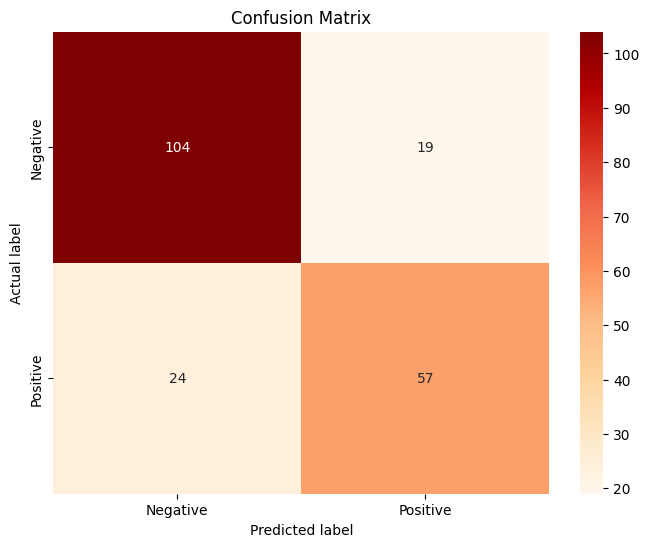

In [6]:
# Confusion Matrix 시각화

plt.figure(figsize=(8, 6))
sns.heatmap(svm_matrix, annot=True, fmt='d', cmap='OrRd', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [7]:
# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



### KNN과 비교하기

In [9]:
# 동일 조건에 knn학습 -> classification_report 결과 확인

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn_model.predict(X_test)

In [10]:
knn_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(knn_matrix)

[[99 24]
 [26 55]]


In [11]:
knn_report = metrics.classification_report(y_test, y_hat)            
print(knn_report)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       123
           1       0.70      0.68      0.69        81

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.75       204



In [15]:
# 최종결과 비교
print(f'<knn_report> {knn_report}')
print(f'<svm_report> {svm_report}')

<knn_report>               precision    recall  f1-score   support

           0       0.79      0.80      0.80       123
           1       0.70      0.68      0.69        81

    accuracy                           0.75       204
   macro avg       0.74      0.74      0.74       204
weighted avg       0.75      0.75      0.75       204

<svm_report>               precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204



#  예제

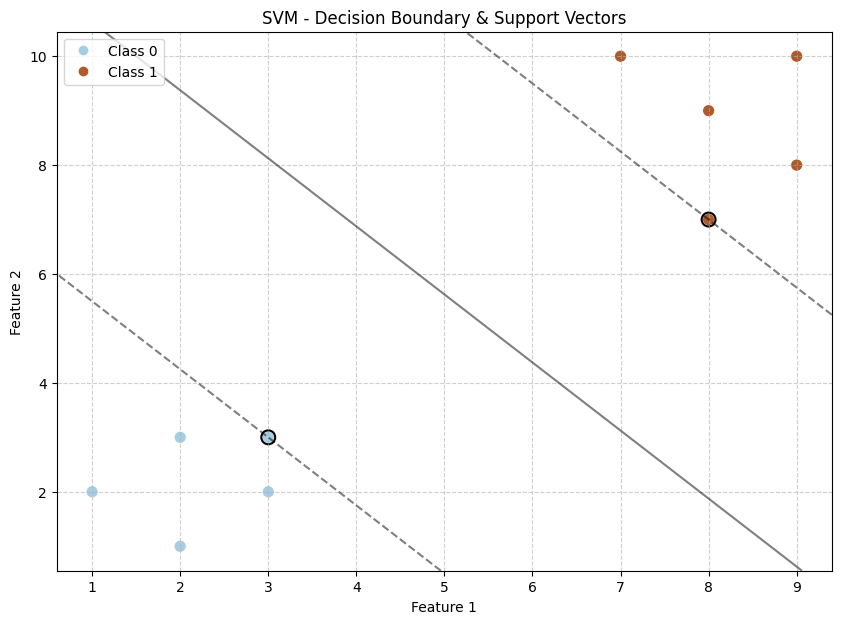

서포트 벡터:
 [[3. 3.]
 [8. 7.]]

서포트 벡터의 인덱스: [2 8]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# 1. 샘플 데이터 생성
# 두 개의 클래스로 명확하게 구분되는 간단한 데이터를 만듭니다.
X = np.array([[1, 2], [2, 3], [3, 3], [2, 1], [3, 2], # 클래스 0
              [8, 9], [7, 10], [9, 10], [8, 7], [9, 8]]) # 클래스 1
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# 2. SVM 모델 생성 및 학습
# 선형 SVM 모델을 생성하고 데이터에 맞게 학습시킵니다.
# kernel='linear'는 직선(초평면)으로 데이터를 나눈다는 의미입니다.
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

# 3. 시각화
plt.figure(figsize=(10, 7))

# 학습 데이터 포인트(산점도) 그리기
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.title('SVM - Decision Boundary & Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# 그래프의 축 범위 가져오기
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 결정 경계를 그리기 위한 그리드 생성
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# 결정 경계와 마진 그리기
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# 서포트 벡터(Support Vectors) 강조해서 그리기
# 서포트 벡터는 모델의 support_vectors_ 속성에 저장되어 있습니다.
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1.5, facecolors='none', edgecolors='k')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 학습된 모델의 정보 출력
print("서포트 벡터:\n", clf.support_vectors_)
print("\n서포트 벡터의 인덱스:", clf.support_)